In [ ]:
import netket as nk
import numpy as np

from scipy.sparse import csr_array
from scipy.sparse.linalg import eigsh

def load_hamiltonian(N, ham_file): 
  # Hamiltonian is truncated to 2^N x 2^N
  ham = np.load(ham_file)[:2**N, :2**N]   # Note the Negative sign 

  lmbd = None
  if N <= 10:
    ham_csr = csr_array(ham)
    lmbd, _ = eigsh(ham_csr, k=1, which='SA')

  return ham, lmbd

In [ ]:
N = 7
ham_file = "Ht_full_CO.npy"
epochs = 400
alpha = 2.0
beta = 1.0
sample_size = 1000
n_chains = 16
lr = 1e-2

H_mat, lmbd = load_hamiltonian(N, ham_file)
print("Ground State energy: ", lmbd)

In [ ]:
hi = nk.hilbert.Spin(s=0.5, N=N)
H = nk.operator.LocalOperator(hi, operators=[H_mat], acting_on=[list(range(N))])

model = nk.models.RBM(alpha=alpha, use_visible_bias=True, param_dtype=complex)
sampler = nk.sampler.MetropolisLocal(hilbert=hi, n_chains=n_chains)

optimizer = nk.optimizer.Adam(learning_rate=lr)
precond = nk.optimizer.SR(diag_shift=1e-3)

vstate = nk.vqs.MCState(sampler, model, n_samples=sample_size)

In [59]:
log = nk.logging.RuntimeLog()

vstate.n_samples = 4000
optimizer.learning_rate = 4e-3

In [60]:
vmc = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=precond)

print("Starting VMC...")
vmc.run(n_iter=100, out=log, show_progress=True)

print("Final ground state energy: ", vstate.expect(H))


Starting VMC...


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\vinit\anaconda3\Lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_generated/errors/netke

Final ground state energy:  1.071-0.039j ± 0.023 [σ²=1.210, R̂=1.0107]


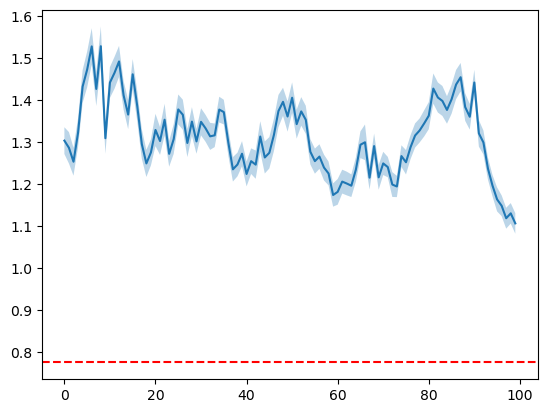

In [61]:
import matplotlib.pyplot as plt
Energy_log = np.real(log['Energy']['Mean'])
std_log = np.real(log['Energy']['Sigma'])

plt.plot(Energy_log)
plt.fill_between(range(len(Energy_log)), Energy_log - std_log, Energy_log + std_log, alpha=0.3)
plt.axhline(y=lmbd, color='r', linestyle='--')

In [62]:
# save the vstate into a file

nk.vqs.save(vstate, "LiCo_Netket_vstate.nk")

AttributeError: module 'netket.vqs' has no attribute 'save'